# Оптимизация гиперпараметров

# Переобучение. Слой Dropout

In [ ]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

%matplotlib inline



# torch.cuda
Используется для настройки и запуска операций CUDA, отслеживает текущий выбранный графический процессор, и все выделяемые тензоры CUDA по умолчанию будут созданы на этом устройстве.
Для изменения выбранного устройства используется метод torch.cuda.device контекстного менеджера.
Описание в документации https://pytorch.org/docs/stable/notes/cuda.html


In [ ]:
# Использование GPU по желанию

if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Работа на GPU')
else:
  device = torch.device('cpu')
  print('Работа на CPU')

# Не забывайте про .to(device)

Работа на GPU


## Загрузка датасета

 В данной работе будет использоваться учебный датасет MNIST
 Создание обучающей и тестовой выборок

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
# Подключение cuda
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# гиперпараметры
random_seed = 1
learning_rate = 0.1
num_epochs = 5
batch_size = 64

num_inputs = 784
n_1 = 128
n_2 = 256
num_classes = 10


train_set = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_set = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
train_set.data.shape, test_set.data.shape

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.59MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, 32, shuffle=True)
test_loader = DataLoader(test_set, 32, shuffle=False)

# Архитектура MLP
В данном примере посторим архитектуру MLP.
при построении модели будем указывать использу.to(device).
На последнем слоя для подсчета ошибки применим функцию ошибки кросс-энтропия F.softmax(outputs, dim=1)
Входные параметры - количество классов и размерность выходного тензора (количество батчей, выходные значения outputs)
Параметр dim=1 описывает измерение, по которому будет вычисляться Softmax (поэтому каждый срез вдоль dim будет в сумме равен 1)..
Описание в документации https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html

При обучении сети будем выводить ошибки по минибатчам, а точность по эпохам, чтобы посмотреть как проходит процесс обуения.

In [ ]:
class MLP (torch.nn.Module):

    def __init__(self, num_inputs, num_classes):
        super(MLP, self).__init__()

        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_inputs, n_1)
        self.linear_2 = torch.nn.Linear(n_1, n_2)

        self.linear_out = torch.nn.Linear(n_2, num_classes)

    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)

        outputs = self.linear_out(out)
        probas = F.softmax(outputs, dim=1)
        return outputs, probas


torch.manual_seed(random_seed)
model = MLP (num_inputs = num_inputs,
                             num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


## Обучение сети
Выведем статистику Loss по минибатчам? accuracy - по эпохам.

In [ ]:
def compute_accuracy(net, data_loader):
    model.eval()
    correct_pred = 0
    num_examples = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs, probas = net(images)
            _, predicted = torch.max(probas, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted == labels).sum()

        return correct_pred.float()/num_examples * 100


for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs, probas = model(images)
        Loss = F.cross_entropy( outputs, labels)
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

        ###
        if not i % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                   %(epoch+1, num_epochs, i,
                     len(train_loader), Loss))

    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
          epoch+1, num_epochs,
          compute_accuracy(model, train_loader)))
    acc= compute_accuracy(model, train_loader)



Epoch: 001/005 | Batch 000/1875 | Loss: 2.3027
Epoch: 001/005 | Batch 050/1875 | Loss: 1.8768
Epoch: 001/005 | Batch 100/1875 | Loss: 0.7909
Epoch: 001/005 | Batch 150/1875 | Loss: 0.4911
Epoch: 001/005 | Batch 200/1875 | Loss: 0.4154
Epoch: 001/005 | Batch 250/1875 | Loss: 0.5757
Epoch: 001/005 | Batch 300/1875 | Loss: 0.3533
Epoch: 001/005 | Batch 350/1875 | Loss: 0.3016
Epoch: 001/005 | Batch 400/1875 | Loss: 0.4732
Epoch: 001/005 | Batch 450/1875 | Loss: 0.2545
Epoch: 001/005 | Batch 500/1875 | Loss: 0.2470
Epoch: 001/005 | Batch 550/1875 | Loss: 0.1679
Epoch: 001/005 | Batch 600/1875 | Loss: 0.1906
Epoch: 001/005 | Batch 650/1875 | Loss: 0.1878
Epoch: 001/005 | Batch 700/1875 | Loss: 0.1178
Epoch: 001/005 | Batch 750/1875 | Loss: 0.2592
Epoch: 001/005 | Batch 800/1875 | Loss: 0.2412
Epoch: 001/005 | Batch 850/1875 | Loss: 0.1231
Epoch: 001/005 | Batch 900/1875 | Loss: 0.1440
Epoch: 001/005 | Batch 950/1875 | Loss: 0.1352
Epoch: 001/005 | Batch 1000/1875 | Loss: 0.1915
Epoch: 001/0

# Dropout
 Построим архитектуру MLP c использованием слоя Dropout, чтобы избежать переобучения
Слой Dropout во время обучения случайным образом обнуляет некоторые элементы входного тензора с вероятностью p.



In [ ]:
dropout = 0.5
class MLP (torch.nn.Module):

    def __init__(self, num_inputs, num_classes):
        super(MLP, self).__init__()

        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_inputs, n_1)
        self.linear_2 = torch.nn.Linear(n_1, n_2)
        self.linear_out = torch.nn.Linear(n_2, num_classes)

    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = F.dropout(out, p=dropout, training=self.training)

        out = self.linear_2(out)
        out = F.relu(out)
        out = F.dropout(out, p=dropout, training=self.training)


        outputs = self.linear_out(out)
        probas = F.softmax(outputs, dim=1)
        return outputs, probas


torch.manual_seed(random_seed)
model = MLP (num_inputs = num_inputs,
                             num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)



In [ ]:
def compute_accuracy(net, data_loader):
    model.eval()
    correct_pred = 0
    num_examples = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs, probas = net(images)
            _, predicted = torch.max(probas, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted == labels).sum()

        return correct_pred.float()/num_examples * 100


for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs, probas = model(images)
        Loss = F.cross_entropy( outputs, labels)
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

        ###
        if not i % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                   %(epoch+1, num_epochs, i,
                     len(train_loader), Loss))

    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
          epoch+1, num_epochs,
          compute_accuracy(model, train_loader)))
    acc= compute_accuracy(model, train_loader)



Epoch: 001/005 | Batch 000/1875 | Loss: 2.3042
Epoch: 001/005 | Batch 050/1875 | Loss: 2.0723
Epoch: 001/005 | Batch 100/1875 | Loss: 1.2883
Epoch: 001/005 | Batch 150/1875 | Loss: 0.8439
Epoch: 001/005 | Batch 200/1875 | Loss: 0.7766
Epoch: 001/005 | Batch 250/1875 | Loss: 0.8026
Epoch: 001/005 | Batch 300/1875 | Loss: 0.5327
Epoch: 001/005 | Batch 350/1875 | Loss: 0.4084
Epoch: 001/005 | Batch 400/1875 | Loss: 0.7288
Epoch: 001/005 | Batch 450/1875 | Loss: 0.5027
Epoch: 001/005 | Batch 500/1875 | Loss: 0.2561
Epoch: 001/005 | Batch 550/1875 | Loss: 0.3500
Epoch: 001/005 | Batch 600/1875 | Loss: 0.4157
Epoch: 001/005 | Batch 650/1875 | Loss: 0.3402
Epoch: 001/005 | Batch 700/1875 | Loss: 0.3066
Epoch: 001/005 | Batch 750/1875 | Loss: 0.3989
Epoch: 001/005 | Batch 800/1875 | Loss: 0.3826
Epoch: 001/005 | Batch 850/1875 | Loss: 0.2284
Epoch: 001/005 | Batch 900/1875 | Loss: 0.2369
Epoch: 001/005 | Batch 950/1875 | Loss: 0.3682
Epoch: 001/005 | Batch 1000/1875 | Loss: 0.4284
Epoch: 001/0

# Нормализация

## Обучение глубоких нейронных сетей
Обучение глубоких нейронных сетей осложняется тем, что распределение входов каждого слоя меняется в процессе обучения, поскольку меняются параметры предыдущих слоев. Это замедляет обучение, требуя тщательной инифиализации параметров.
Это явление называется внутренним ковариационным сдвигом и решается  путем нормализации входов слоев.
Основа метода заключается в том, что нормализация является частью архитектуры модели и выполняется для каждого минибатча
Пакетная нормализация позволяет  использовать гораздо более высокие скорости обучения. Она также действует как регуляризатор, в некоторых случаях устраняя необходимость в Dropout.



## Создание архитектуры сети
В данной работе будут использоваться слои нормализации для предотвращения внутреннего ковариационного сдвига в

Слой нормализации - класс  torch.nn.BatchNorm1d(C) C — размерность каналов входных данных
torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)

Среднее значение и стандартное отклонение рассчитываются для каждого измерения мини-батчей: γ и β — это обучаемые векторы параметров размера C. По умолчанию элементы  γ установлены в 1, а элементы β установлены на 0.
Также по умолчанию во время обучения этот слой продолжает выполнять оценки вычисленного среднего значения и дисперсии, которые затем используются для нормализации во время оценки. Текущие оценки сохраняются со значением momentum по умолчанию 0,1.
Описание в документации https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

Ниже представлена архитектура MLP с подключением слоя нормализации перед активационной функцией.


In [ ]:
class MLP_1(torch.nn.Module):

    def __init__(self, num_inputs, num_classes):
        super(MLP_1, self).__init__()

        ### 1 скрытый слой
        self.linear_1 = torch.nn.Linear(num_inputs, n_1)
        # Подключение слоя нормализации перед активационной функцией
        # которая стандартно используется
        self.linear_1_bn = torch.nn.BatchNorm1d(n_1)

        ### 2 скрытый слойr
        self.linear_2 = torch.nn.Linear(n_1, n_2)
        self.linear_2_bn = torch.nn.BatchNorm1d(n_2)

        ### выходной слой
        self.linear_out = torch.nn.Linear(n_2, num_classes)


    def forward(self, x):
        out = self.linear_1(x)
        # Как правило, перед активационной функцией используется нормализация
        out = self.linear_1_bn(out)
        out = F.relu(out)

        out = self.linear_2(out)
        out = self.linear_2_bn(out)
        out = F.relu(out)

        outputs = self.linear_out(out)
        probas = F.softmax( outputs, dim=1)
        return  outputs, probas


torch.manual_seed(random_seed)
model = MLP_1(num_inputs=num_inputs,
                             num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def compute_accuracy(net, data_loader):
    model.eval()
    correct_pred = 0
    num_examples = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs, probas = net(images)
            _, predicted = torch.max(probas, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted == labels).sum()

        return correct_pred.float()/num_examples * 100


for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs, probas = model(images)
        Loss = F.cross_entropy( outputs, labels)
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

        ###
        if not i % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                   %(epoch+1, num_epochs, i,
                     len(train_loader), Loss))

    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
          epoch+1, num_epochs,
          compute_accuracy(model, train_loader)))
    acc= compute_accuracy(model, train_loader)

a

Epoch: 001/005 | Batch 000/1875 | Loss: 2.4006
Epoch: 001/005 | Batch 050/1875 | Loss: 0.4368
Epoch: 001/005 | Batch 100/1875 | Loss: 0.4018
Epoch: 001/005 | Batch 150/1875 | Loss: 0.3746
Epoch: 001/005 | Batch 200/1875 | Loss: 0.3750
Epoch: 001/005 | Batch 250/1875 | Loss: 0.4539
Epoch: 001/005 | Batch 300/1875 | Loss: 0.1526
Epoch: 001/005 | Batch 350/1875 | Loss: 0.0460
Epoch: 001/005 | Batch 400/1875 | Loss: 0.2842
Epoch: 001/005 | Batch 450/1875 | Loss: 0.1574
Epoch: 001/005 | Batch 500/1875 | Loss: 0.1929
Epoch: 001/005 | Batch 550/1875 | Loss: 0.2029
Epoch: 001/005 | Batch 600/1875 | Loss: 0.1312
Epoch: 001/005 | Batch 650/1875 | Loss: 0.0752
Epoch: 001/005 | Batch 700/1875 | Loss: 0.0962
Epoch: 001/005 | Batch 750/1875 | Loss: 0.2195
Epoch: 001/005 | Batch 800/1875 | Loss: 0.0534
Epoch: 001/005 | Batch 850/1875 | Loss: 0.1911
Epoch: 001/005 | Batch 900/1875 | Loss: 0.2001
Epoch: 001/005 | Batch 950/1875 | Loss: 0.0528
Epoch: 001/005 | Batch 1000/1875 | Loss: 0.0730
Epoch: 001/0

In [ ]:
model.eval()  # Переключение модели в режим оценки
correct_pred = 0
num_examples = 0
with torch.no_grad():  # Отключение вычисления градиентов
    for images, labels in test_loader:
        images = images.view(-1, 28 * 28).to(device)  # Преобразование и перенос на устройство
        labels = labels.to(device)  # Перенос меток на устройство
        outputs, probas = model(images)  # Получение вывода модели
        _, predicted = torch.max(probas, 1)  # Получение предсказанных классов
        num_examples += labels.size(0)  # Подсчет общего числа примеров
        correct_pred += (predicted == labels).sum()  # Подсчет правильных предсказаний

tensor_value = correct_pred.float() / num_examples * 100
value = tensor_value.cpu().item()

# Выводим значение
print(f"Значение: {value:.4f}")

Значение: 98.0800


## Создание архитектуры сети с подключением слоя нормализации после активационной функции

Создайте архитектуру MLP с подключением слоя нормализации после активационной функцией.
Обучите сеть
выведите результаты.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Архитектура MLP
class MLP_1(nn.Module):
    def __init__(self, num_inputs, num_classes):
        super(MLP_1, self).__init__()

        ### 1 скрытый слой
        self.linear_1 = nn.Linear(num_inputs, n_1)
        self.linear_1_bn = nn.BatchNorm1d(n_1)  # Слой нормализации

        ### 2 скрытый слой
        self.linear_2 = nn.Linear(n_1, n_2)
        self.linear_2_bn = nn.BatchNorm1d(n_2)  # Слой нормализации

        ### Выходной слой
        self.linear_out = nn.Linear(n_2, num_classes)

    def forward(self, x):
        # Первый слой
        out = self.linear_1(x)
        out = F.relu(out)  # Активационная функция
        out = self.linear_1_bn(out)  # Нормализация после активации

        # Второй слой
        out = self.linear_2(out)
        out = F.relu(out)  # Активационная функция
        out = self.linear_2_bn(out)  # Нормализация после активации

        # Выходной слой
        outputs = self.linear_out(out)
        probas = F.softmax(outputs, dim=1)  # Вероятности классов
        return outputs, probas


# Инициализация модели
torch.manual_seed(random_seed)
model = MLP_1(num_inputs=num_inputs, num_classes=num_classes)
model = model.to(device)

# Оптимизатор
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, _ = model(images)
        loss = F.cross_entropy(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Логирование каждые 100 батчей
        if not batch_idx % 100:
            print(
                f"Epoch: {epoch + 1}/{num_epochs} | Batch: {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}"
            )

    # Вычисление точности на обучающей и тестовой выборках
    train_acc = compute_accuracy(model, train_loader)
    test_acc = compute_accuracy(model, test_loader)
    print(
        f"Epoch: {epoch + 1}/{num_epochs} | Train Accuracy: {train_acc:.2f}% | Test Accuracy: {test_acc:.2f}%"
    )

Epoch: 1/5 | Batch: 0/1875 | Loss: 2.5260
Epoch: 1/5 | Batch: 100/1875 | Loss: 0.3775
Epoch: 1/5 | Batch: 200/1875 | Loss: 0.2336
Epoch: 1/5 | Batch: 300/1875 | Loss: 0.0631
Epoch: 1/5 | Batch: 400/1875 | Loss: 0.2843
Epoch: 1/5 | Batch: 500/1875 | Loss: 0.1853
Epoch: 1/5 | Batch: 600/1875 | Loss: 0.0914
Epoch: 1/5 | Batch: 700/1875 | Loss: 0.0664
Epoch: 1/5 | Batch: 800/1875 | Loss: 0.1701
Epoch: 1/5 | Batch: 900/1875 | Loss: 0.1947
Epoch: 1/5 | Batch: 1000/1875 | Loss: 0.0710
Epoch: 1/5 | Batch: 1100/1875 | Loss: 0.1029
Epoch: 1/5 | Batch: 1200/1875 | Loss: 0.2284
Epoch: 1/5 | Batch: 1300/1875 | Loss: 0.0940
Epoch: 1/5 | Batch: 1400/1875 | Loss: 0.5307
Epoch: 1/5 | Batch: 1500/1875 | Loss: 0.0270
Epoch: 1/5 | Batch: 1600/1875 | Loss: 0.2173
Epoch: 1/5 | Batch: 1700/1875 | Loss: 0.0895
Epoch: 1/5 | Batch: 1800/1875 | Loss: 0.2046
Epoch: 1/5 | Train Accuracy: 97.07% | Test Accuracy: 96.71%
Epoch: 2/5 | Batch: 0/1875 | Loss: 0.1332
Epoch: 2/5 | Batch: 100/1875 | Loss: 0.0201
Epoch: 2/5 

#  Аугментация

Один из методов борьбы с переобучением является увеличение выборки с использованием аугментации
, можно воспользоваться базовым классом `ImageFolder`.
при помощи параметра `transform` можно скомпоновать преобразования для изображений. (лабораторная работа №2)

Для компоновки функции из модуля v2 используйте `Compose`.Параметры:
* ToImage() - преобразование в `Image` (подкласс torch.Tensor)
* RandomVerticalFlip() - случайное отзеркаливание
* ToDtype(torch.float32, scale=True) - преобразование из int во float
* Normalize() - нормализация изображений по полученным средним и стандартным отклонениям.

По желанию:
* RandomRotation() - поворот на случайный угол в указанном диапазоне
* Можете попробовать и другие варианты преобразований. [Документация API V2](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

 При обучении используете весь набор обязательных преобразований, при проверке требуется только преобразовать изображение к тензору с плавающей точкой и провести нормализацию.

# Задание 1.
 Загрузить датасет bus для решения задачи классификации входящих и выхдящих пассажиров. Провести аугментацию датчсета с
  использованием , создать 3 архитектуры сети, провести обучение с использованием обучающей и валидационной выборок, проверить на тестовой выборке, вывесит лучшую архитектуру.

## Порядок выполнения

1. Загрузить датасет bus для решения задачи классификации;
2. Подготовить transforms, DataSet и DataLoader;
3. Создать 3 архитектуры сети c использованием слоя Batchnorm2d, за основу можно взять архитектуру LeNet. Документация Batchnorm2d https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
4. Обучите сеть и выведите графики результатов на тренировочной и валидационной выборках.
5. Оценить результаты лучшей модели на тестовой выборке.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt

DATA_DIR = "/content/drive/MyDrive/bus"

train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

class LeNetBatchNorm(nn.Module):
    def __init__(self):
        super(LeNetBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        self.flatten_size = 64 * 8 * 8
        self.fc1 = nn.Linear(self.flatten_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_and_evaluate(model, train_loader, val_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

models = [LeNetBatchNorm(), LeNetBatchNorm(), LeNetBatchNorm()]
results = []
for i, model in enumerate(models):
    print(f"Training Model {i+1}")
    train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader)
    results.append((model, train_losses, val_losses))

best_model = min(results, key=lambda x: min(x[2]))[0]

def evaluate_on_test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_on_test(best_model, test_loader)


Training Model 1
Epoch 1/10 - Train Loss: 0.3844 - Val Loss: 0.2758
Epoch 2/10 - Train Loss: 0.2105 - Val Loss: 0.1591
Epoch 3/10 - Train Loss: 0.1403 - Val Loss: 0.1353
Epoch 4/10 - Train Loss: 0.0797 - Val Loss: 0.1059
Epoch 5/10 - Train Loss: 0.0722 - Val Loss: 0.1735
Epoch 6/10 - Train Loss: 0.0534 - Val Loss: 0.0726
Epoch 7/10 - Train Loss: 0.0310 - Val Loss: 0.0452
Epoch 8/10 - Train Loss: 0.0267 - Val Loss: 0.0603
Epoch 9/10 - Train Loss: 0.0122 - Val Loss: 0.0409
Epoch 10/10 - Train Loss: 0.0315 - Val Loss: 0.0500
Training Model 2
Epoch 1/10 - Train Loss: 0.4099 - Val Loss: 0.2912
Epoch 2/10 - Train Loss: 0.2427 - Val Loss: 0.2127
Epoch 3/10 - Train Loss: 0.1784 - Val Loss: 0.1430
Epoch 4/10 - Train Loss: 0.1040 - Val Loss: 0.1075
Epoch 5/10 - Train Loss: 0.0813 - Val Loss: 0.0786
Epoch 6/10 - Train Loss: 0.0609 - Val Loss: 0.0598
Epoch 7/10 - Train Loss: 0.0340 - Val Loss: 0.0750
Epoch 8/10 - Train Loss: 0.0451 - Val Loss: 0.0515
Epoch 9/10 - Train Loss: 0.0146 - Val Loss: 0.1

#  Задание 2.

Порядок выполнения
1.  Загрузите датасет fmr.zip.
2.	Создайте 3 архитектуры сверточной нейронной сети для распознавания данных из набора fmr.zip. Обучите сеть и выведите результаты на тренировочной и валидационной выборках.
4.	Проверьте работу сети на тестовой выборке. Добейтесь точности не менее 85%.
5.	Загрузите файлы с картинками из интернета или создайте свои фотографии.
6.	Проверьте работу сети на собственных картинках.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

DATA_DIR = "/content/drive/MyDrive/fmr"

train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = data.random_split(full_dataset, [train_size, val_size, test_size])

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

class LeNetBatchNorm(nn.Module):
    def __init__(self, num_classes):
        super(LeNetBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_and_evaluate(model, train_loader, val_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_losses.append(val_loss / len(val_loader))
        val_acc = correct / total * 100

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f} - Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses

num_classes = len(full_dataset.classes)
model = LeNetBatchNorm(num_classes)
print("Training Model")
train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader)

def evaluate_on_test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_on_test(model, test_loader)

def predict_image(model, image_path):
    image = Image.open(image_path).convert("RGB")
    transform = test_transform
    image = transform(image).unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        _, predicted = torch.max(output, 1)
    class_names = full_dataset.classes
    return class_names[predicted.item()]

image_path = "ferrari_example.png"
print("Predicted:", predict_image(model, image_path))


Train: 2398, Val: 514, Test: 515
Training Model
Epoch 1/10 - Train Loss: 0.9353 - Val Loss: 0.9433 - Val Acc: 56.42%
Epoch 2/10 - Train Loss: 0.8574 - Val Loss: 0.9563 - Val Acc: 56.81%
Epoch 3/10 - Train Loss: 0.8206 - Val Loss: 0.8920 - Val Acc: 60.70%
Epoch 4/10 - Train Loss: 0.7978 - Val Loss: 0.8633 - Val Acc: 59.53%
Epoch 5/10 - Train Loss: 0.7872 - Val Loss: 0.8681 - Val Acc: 60.51%
Epoch 6/10 - Train Loss: 0.7592 - Val Loss: 0.9002 - Val Acc: 60.89%
Epoch 7/10 - Train Loss: 0.7485 - Val Loss: 0.8557 - Val Acc: 61.09%
Epoch 8/10 - Train Loss: 0.7216 - Val Loss: 0.8598 - Val Acc: 59.73%
Epoch 9/10 - Train Loss: 0.7186 - Val Loss: 0.9443 - Val Acc: 60.70%
Epoch 10/10 - Train Loss: 0.6854 - Val Loss: 0.8755 - Val Acc: 62.45%
Test Accuracy: 65.83%
Predicted: Ferrari


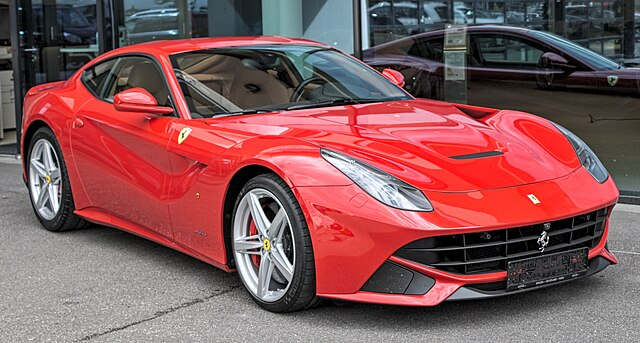